In [1]:
#import Pkg
#Pkg.activate("packages")
#Pkg.instantiate()
using CSV, DataFrames, Plots, Plots.PlotMeasures, StatsPlots, Statistics

In [2]:
my_col = cgrad(:tol_bright, categorical=true, 17)

In [3]:
# Global parameters
N0 = 10^4
Nf = 10^9
nu_off = 10^-8.
gamma_off = 1.
nu_on = 10^-6.
delta_off = 0.;

## Mutant count distributions

In [153]:
# Reading the (true) input parameters
# Mutation-rate increase = 100 or 10
i = 100
range_1 = "range-gamma_on-increase$i"
true_para = DataFrame(CSV.File("input_parameters/"*range_1*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / gamma_off
mu_off_true = nu_off/gamma_off
mu_on_true = true_para.nu_on[1]/gamma_off
include("inference.jl")
mc_data = Matrix(DataFrame(CSV.File("output_data/mutant_counts-"*range_1*".csv")))
p_final = Matrix(DataFrame(CSV.File("output_data/p_final-"*range_1*".csv")))
mu_het_true = (p_final[2,:] .* mu_on_true ./ ((1 .- p_final[2,:]) .* mu_off_true))[1:end-1]
m_true = nu_off .* p_final[1,:];

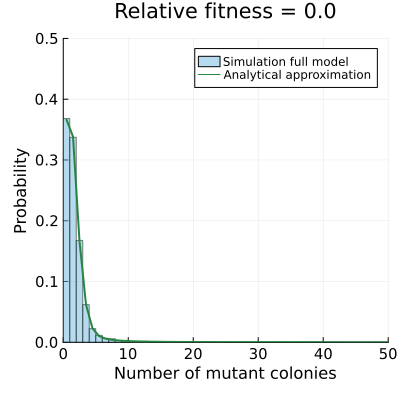

In [76]:
j = 1       # Relative division rate of response-on cells
m_max = 50
P_mc = plot(size=(400,400), tickfontsize=10)
plot!(title="Relative fitness = $(range_para[j]), increase = $i", xlab="Number of mutant colonies", ylab="Probability")
histogram!(mc_data[:,j], lab="Simulation full model", xlim=(0,m_max), bins=0:m_max, normalized=true, c=my_col[12], alpha=0.5, ylim=(0,0.5))
plot!(collect(0:m_max).+0.5, pdf_mudi(m_max, m_true[j], mu_het_true[j], false), width=2, lab="Analytical approximation", c=my_col[4])
#scatter!(empirical_cdf(mc_data[:,j]), lab="Simulation full model", xlim=(0,m_max), c=my_col[12], ylim=(0,1))
#plot!(collect(0:m_max).+0.5, cdf_mudi(pdf_mudi(m_max, m_true[j], mu_het_true[j], false)), width=2, lab="Analytical approximation", c=my_col[4])

In [154]:
include("population_dynamics.jl")
mc = mutant_count(10, 10^4, 1., 10^-8, 0., 0., 0., 10^5)
mc_p = mc[1:end-2][1]
mc = mutant_count(10, 10^4, 1., 3*10^-8, 0., 0., 0., 10^5)
mc_hom = mc[1:end-2][1]
mc = mutant_count(10, 10^4, 1., 3*10^-8, 0., 0., 0., 10^5, fitness_m_off=0.5)
mc_hom_2 = mc[1:end-2][1]
mc = mutant_count(10, 10^4, 1., 3*10^-8, 0., 0., 0., 10^5, fitness_m_off=0.)
mc_hom_3 = mc[1:end-2][1]
mc = mutant_count(10, 10^4, 1., 10^-8, 0.05, 0., (3/0.95-1)*0.95/0.05*10^-8, 10^5)
mc_het = mc[1:end-2][1]
mc = mutant_count(10, 10^4, 1., 10^-8, 0.05, 0.5, (3/0.95-1)*0.95/0.05*10^-8, 10^5)
mc_het_2 = mc[1:end-2][1]
mc = mutant_count(10, 10^4, 1., 10^-8, 0.05, 1., (3/0.95-1)*0.95/0.05*10^-8, 10^5)
mc_het_3 = mc[1:end-2][1];

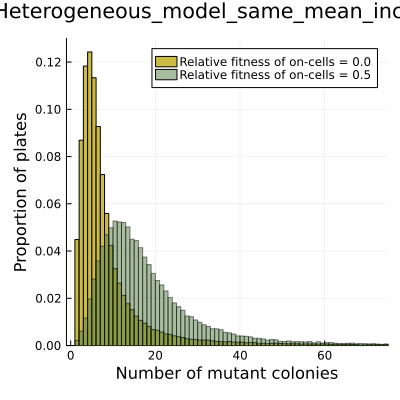

In [159]:
P_mc = plot(size=(400,400), xlim=(-1,75), ylim=(0,0.13))

#t = "Permissive_condition"
#histogram!(mc_p, bins=0:100, normalized=true, lab="", c=my_col[2])

#t = "Homogeneous_model_3-fold_increase"
#histogram!(mc_hom, bins=0:100, normalized=true, c=my_col[16], lab="Mutant fitness under stress = 1.0")
#histogram!(mc_hom_2, bins=0:100, normalized=true, alpha=0.5, c=my_col[6], lab="Mutant fitness under stress = 0.5")

t = "Heterogeneous_model_same_mean_increase"
histogram!(mc_het, bins=1:100, normalized=true, lab="Relative fitness of on-cells = 0.0", c=my_col[9])
histogram!(mc_het_2, bins=1:100, normalized=true, alpha=0.5, lab="Relative fitness of on-cells = 0.5", c=my_col[3])

plot!(title=t, xlab="Number of mutant colonies", ylab="Proportion of plates", legend=:topright)
#plot!(legend=:false)

In [160]:
savefig(P_mc, "figures/Figure_1_$t.pdf")

## Accuracy and Precision

In [32]:
# Reading the (true) input parameters
range_1 = "range-nu_on"
range_2 = "range-alpha-f0"
true_para_1 = DataFrame(CSV.File("input_parameters/"*range_1*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*range_2*".csv"))
range_para_1 = 10 .^ collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) / nu_off
range_para_2 = 10 .^ collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1]) / gamma_off
J1 = length(range_para_1)
J2 = length(range_para_2)
range_2 *= "/"
mu_off_true = nu_off/gamma_off;

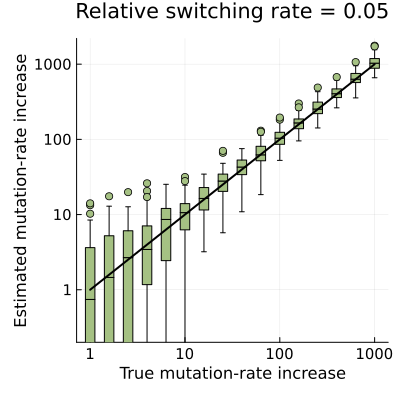

In [33]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Estimated compared to true mutation-rate increase for R=100 simulations; switching rate = 0.05
n = 50                          # Also for smaller numbers of parallel cultures n=20,10
P_inc = plot(size=(400,400))
r = 18                          # Switching rate = 0.05
for j1 = 1:2:J1
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-log_alpha_$r/het_zero-div-number_cultures_$n-log_nu_on_$j1.csv")))
    for i in 1:size(inferred_para)[2]
        if inferred_para[16,i] == 0.
            inferred_para[16,i] = 10^-1.
        end
    end
    boxplot!([j1], inferred_para[16,:], lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:10:J1), Int.(round.(range_para_1[1:10:J1]))), yticks=(range_para_1[1:10:J1], Int.(round.(range_para_1[1:10:J1]))), yscale=:log10, ylim=(0.2, 2200))
plot!(range_para_1, c=:black, width=2, lab="", tickfontsize=10, draw_arrow=true)
plot!(ylab="Estimated mutation-rate increase", xlab="True mutation-rate increase", title="Relative switching rate = $(round(range_para_2[r], digits=3))")

In [6]:
# Determining numerical values for the precision
i = 15
inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-log_alpha_$r"*m*"-number_cultures_$n-log_nu_on_$i.csv")))
println("True mutation-rate increase = ", range_para_1[i])
println("25 and 75 percent quantiles: ", quantile(inferred_para[16,:], [0.05,0.95])/ range_para_1[i])
println("")
i = 12
inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-log_alpha_$r"*m*"-number_cultures_$n-log_nu_on_$i.csv")))
println("True mutation-rate increase = ", range_para_1[i])
q2, q4 = quantile(inferred_para[16,:], [0.25, 0.75])
IQR = q4 - q2
println("Maximum estimated mutation-rate = ", maximum((inferred_para[16,:])[inferred_para[16,:] .< q4 + 1.5*IQR]))
println("")
i = 12
inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-log_alpha_$r"*m*"-number_cultures_$n-log_nu_on_$i.csv")))
println("True mutation-rate increase = ", range_para_1[i])
q2, q4 = quantile(inferred_para[16,:], [0.25, 0.75])
IQR = q4 - q2
println("Minimum estimated mutation-rate = ", minimum((inferred_para[16,:])[inferred_para[16,:] .> q2 - 1.5*IQR]))

True mutation-rate increase = 25.118864315095824
25 and 75 percent quantiles: [0.5600639321196937, 1.8459765892799738]

True mutation-rate increase = 12.589254117941662
Maximum estimated mutation-rate = 27.8751976393923

True mutation-rate increase = 12.589254117941662
Minimum estimated mutation-rate = 2.9423650927776244e-8


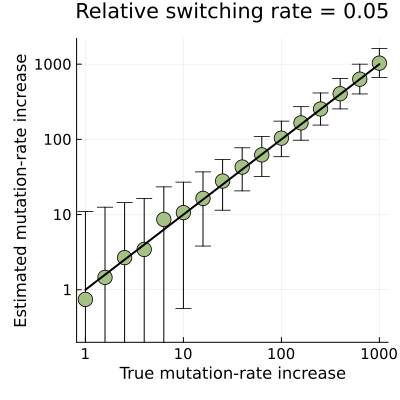

In [34]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Estimated compared to true mutation-rate increase (median confidence intervals); switching rate = 0.05
n = 50                              # Also for smaller numbers of parallel cultures n=20,10
P_inc_CI = plot(size=(400,400))
r = 18                              # Switching rate = 0.05
for j1 = 1:2:J1
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-log_alpha_$r/het_zero-div-number_cultures_$n-log_nu_on_$j1.csv")))
    no_CI = Vector{Int}(undef, 0)
    for i in 1:size(inferred_para)[2]
        if (inferred_para[17,i] == inferred_para[16,i]) || (inferred_para[18,i] == inferred_para[16,i])
            push!(no_CI, i)
        end 
        if inferred_para[17,i] == 0.        # Y scale in log
            inferred_para[17,i] = 10^-1.
        end
    end
    scatter!([j1], [median(inferred_para[16,:])], yerror=([median(inferred_para[16,:].-inferred_para[17,:])], [median(inferred_para[18,:].-inferred_para[16,:])]), lab="", c=my_col[10], markersize=8)
end
plot!(xticks=(collect(1:10:J1), Int.(round.(range_para_1[1:10:J1]))), yticks=(range_para_1[1:10:J1], Int.(round.(range_para_1[1:10:J1]))), yscale=:log10, ylim=(0.2, 2200))
plot!(range_para_1, c=:black, width=2, lab="", tickfontsize=10, draw_arrow=true)
plot!(ylab="Estimated mutation-rate increase", xlab="True mutation-rate increase", title="Relative switching rate = $(round(range_para_2[r], digits=3))")

In [15]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Estimated value is below/above the 95% confidence interval; or calculation of confidence interval failed
n = 50                              # Also for smaller numbers of parallel cultures n=20,10
r = 18                              # Switching rate = 0.05
above_CI = zeros(Int, J1)
below_CI = zeros(Int, J1)
no_CI = zeros(Int, J1)
for j1 = 1:J1
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-log_alpha_$r/het_zero-div-number_cultures_$n-log_nu_on_$j1.csv")))
    below_CI[j1] = sum(inferred_para[18,:] .< range_para_1[j1]) 
    above_CI[j1] = sum(inferred_para[17,:] .> range_para_1[j1])
    no_CI[j1] = sum(inferred_para[17,:] .== inferred_para[16,:]) + sum(inferred_para[18,:] == inferred_para[16,:])
end

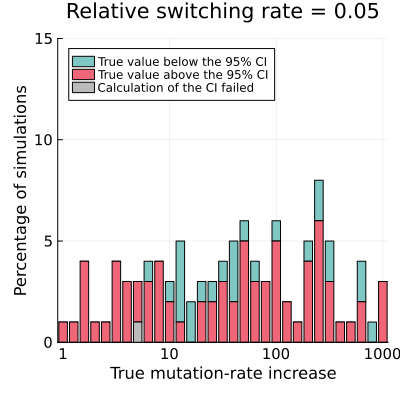

In [16]:
P_CI_95 = groupedbar([below_CI above_CI no_CI], bar_position=:stack, c=[my_col[11] my_col[1] my_col[17]], label=["True value below the 95% CI" "True value above the 95% CI" "Calculation of the CI failed"])
#hline!([mean(above_CI)+mean(below_CI)], c=my_col[17], lab="Average out of the 95% CI", width=2)
plot!(size=(400,400), tickfontsize=10)
plot!(xticks=(collect(1:10:J1), Int.(round.(range_para_1[1:10:J1]))), ylim=(0,15), legend=:topleft, xlim=(0.5,J1+0.5))
plot!(xlab="True mutation-rate increase", ylab="Percentage of simulations", title="Relative switching rate = $(round(range_para_2[r], digits=3))")
#plot!(legend=:false)

In [17]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Relative error, coefficient of variation and median width of CIs across R=100 simulations 
n = 50                                          # Also for smaller numbers of parallel cultures n=20,10
RE_alpha_mu = Matrix{Float64}(undef, (J2, J1))
CV_alpha_mu = Matrix{Float64}(undef, (J2, J1))
CI_alpha_mu = Matrix{Float64}(undef, (J2, J1))
for j2 = 1:J2
    for j1 = 1:J1
        inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-log_alpha_$j2/het_zero-div-number_cultures_$n-log_nu_on_$j1.csv")))
        RE_alpha_mu[j2, j1] = (median(inferred_para[16,:]) - range_para_1[j1]) / range_para_1[j1]
        CV_alpha_mu[j2, j1] = std(inferred_para[16,:]) / mean(inferred_para[16,:])
        CI_alpha_mu[j2, j1] = (median(inferred_para[18,:] .- inferred_para[17,:])) / range_para_1[j1]
    end
end

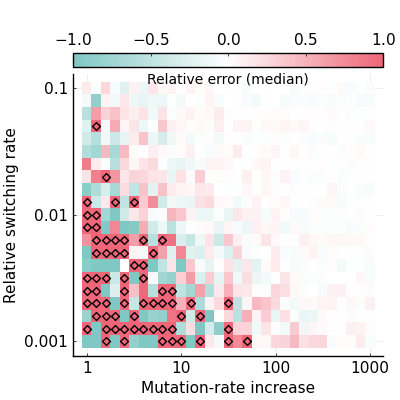

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [18]:
pyplot()
c_max = 1
c_min = -1
P_RE = plot(size=(400,400))
heatmap!(RE_alpha_mu, c=cgrad([my_col[11], :white, my_col[1]], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max), cb=:top, colorbar_tickfontsize=11)
for i = 1:size(RE_alpha_mu)[2]
    for j = 1:size(RE_alpha_mu)[1]
        if abs(RE_alpha_mu[j,i]) > 1
            scatter!([i], [j], lab="", c=my_col[1], marker=:diamond)
        end
    end
end 
plot!(xticks=(collect(1:10:J1), Int.(round.(range_para_1[1:10:J1]))), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=11)
plot!(colorbar_title="Relative error (median)", xlab="Mutation-rate increase", ylab="Relative switching rate")

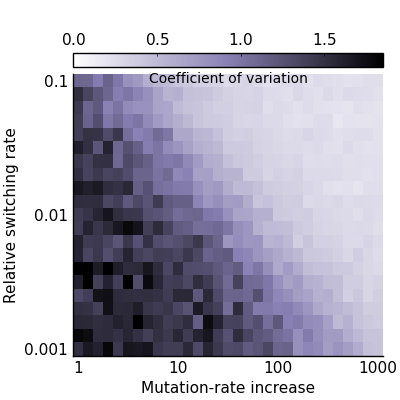

In [19]:
P_CV = plot(size=(400,400))
heatmap!(CV_alpha_mu, c=cgrad([:white, my_col[13], :black]), clim=(0, 1.85), cb=:top, colorbar_tickfontsize=11)
plot!(xticks=(collect(1:10:J1), Int.(round.(range_para_1[1:10:J1]))), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=11)
plot!(colorbar_title="Coefficient of variation", xlab="Mutation-rate increase", ylab="Relative switching rate")

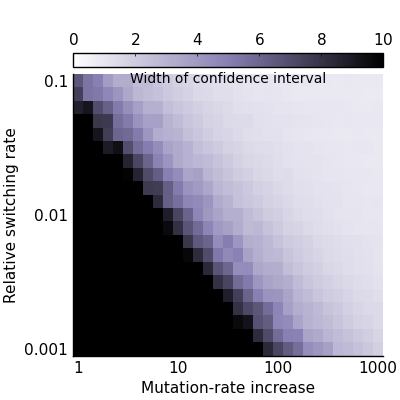

In [20]:
P_CI = plot(size=(400,400))
heatmap!(CI_alpha_mu, c=cgrad([:white, my_col[13], :black]), clim=(0, 10), cb=:top, colorbar_tickfontsize=11)
plot!(xticks=(collect(1:10:J1), Int.(round.(range_para_1[1:10:J1]))), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=11)
plot!(colorbar_title="Width of confidence interval", xlab="Mutation-rate increase", ylab="Relative switching rate")

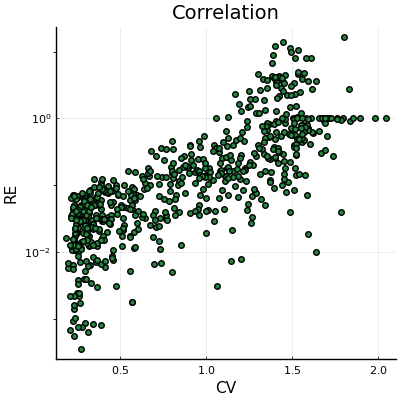

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [29]:
plot(size=(400,400), ylab="RE", title="Correlation")
scatter!(CV_alpha_mu, abs.(RE_alpha_mu), lab="", yscale=:log10, c=my_col[4], xlab="CV")
#scatter!(CI_alpha_mu, abs.(RE_alpha_mu), lab="", yscale=:log10, xscale=:log10, c=my_col[12], xlab="Width of CI")

In [158]:
savefig(P_inc, "figures/Figure_2A_$n.pdf")
savefig(P_inc_CI, "figures/Figure_2A_CI_$n.pdf")
savefig(P_CI_95, "figures/Figure_2_CI_$n.pdf")
savefig(P_RE, "figures/Figure_2B_$n.png")
savefig(P_CV, "figures/Figure_2C_$n.png")
savefig(P_CI, "figures/Figure_2C_CI_$n.png")
gr()

Plots.GRBackend()

## Impact of cell death

In [35]:
# Reading the (true) input parameters
# Switching rate = 0.05 or 0.01
i = 5
range_1 = "range-delta_off-alpha$i"
range_2 = "range-delta_on-alpha$i"
true_para = DataFrame(CSV.File("input_parameters/"*range_1*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1])
J = length(range_para)
range_2 *= "/"
mu_on_true = true_para.nu_on[1]/gamma_off;

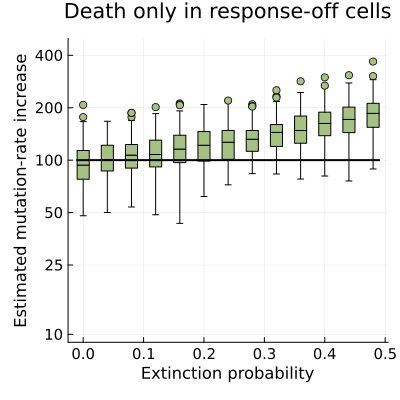

In [36]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
P_inc_off = plot(size=(400,400))
for j = 1:2:J
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-delta_on_1/het_zero-div-number_cultures_50-delta_off_$j.csv")))
    boxplot!([j], inferred_para[16,:], lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(title="Death only in response-off cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase")

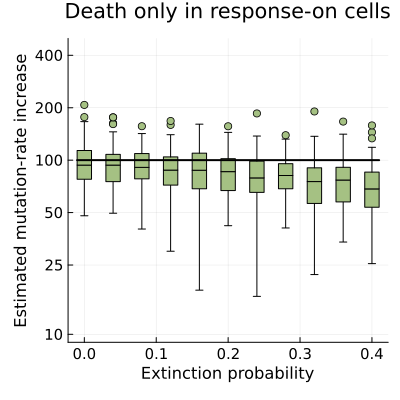

In [37]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
P_inc_on = plot(size=(400,400))
for j = 1:2:J2
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-delta_on_$j/het_zero-div-number_cultures_50-delta_off_1.csv")))
    boxplot!([j], inferred_para[16,:], lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(title="Death only in response-on cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase")

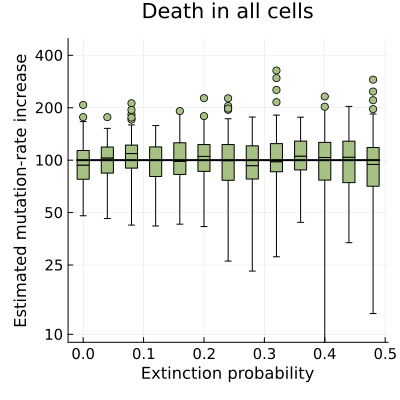

In [38]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
P_inc_all = plot(size=(400,400))
for j = 1:2:J
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*"-delta_on_$j/het_zero-div-number_cultures_50-delta_off_$j.csv")))
    boxplot!([j], inferred_para[16,:], lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([10,25,50,100,200,400], [10,25,50,100,200,400]), ylim=(9,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(title="Death in all cells", xlab="Extinction probability", ylab="Estimated mutation-rate increase")

In [107]:
savefig(P_inc_off, "figures/Figure_3A_$i.pdf")
savefig(P_inc_on, "figures/Figure_3B_$i.pdf")
savefig(P_inc_all, "figures/Figure_3C_$i.pdf")

## Impact of differential mutant fitness

In [39]:
# Reading the (true) input parameters
range_1 = "range-rho"
true_para = DataFrame(CSV.File("input_parameters/"*range_1*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1])
J = length(range_para)
mu_off_true = nu_off/gamma_off
mu_on_true = true_para.nu_on[1]/gamma_off;

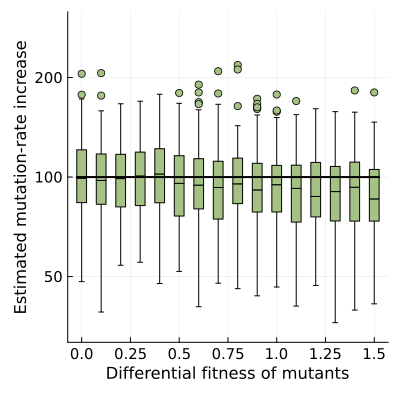

In [41]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
P_inc_fit = plot(size=(400,400))
for j = 1:2:J
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_1*"/het_zero-div-number_cultures_50-rho_$j.csv")))
    boxplot!([j], inferred_para[16,:], lab="", c=my_col[10], bar_width=1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.5, 10^2.5), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Differential fitness of mutants", ylab="Estimated mutation-rate increase")

In [164]:
# Determining numerical values for the precision
RE = 0
for j = 1:J
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_1*m*"-number_cultures_50-rho_$j.csv")))
    RE = maximum([RE, maximum(abs((median(inferred_para[16,:]) - mu_on_true/mu_off_true)*mu_off_true/mu_on_true))])
end
RE

0.16251424401840808

In [363]:
savefig(P_inc_fit, "figures/Figure_A.pdf")

## Estimation when response-on cells have a non-zero division rate.

In [58]:
# Reading the (true) input parameters
p = "range-gamma_on-increase100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / gamma_off
J = length(range_para)
mu_off_true = nu_off/gamma_off
mu_on_true = true_para.nu_on[1]/gamma_off;

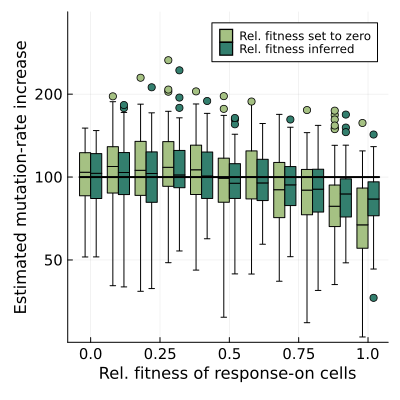

In [59]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# Estimated compared to true mutation-rate increase; estimated compared to true rel. division rate of response-on cells
m_1 = "/het_zero-div"
m_2 = "/het_infer-div"
P_inc_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*m_1*"-number_cultures_50-gamma_on_$j.csv")))
    inferred_para_2 = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*m_2*"-number_cultures_50-gamma_on_$j.csv")))
    boxplot!([j-0.4], inferred_para_1[16,:], lab="", c=my_col[10])
    boxplot!([j+0.4], inferred_para_2[16,:], lab="", c=my_col[5])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Rel. fitness of response-on cells", ylab="Estimated mutation-rate increase")
scatter!([0], [1], lab="Rel. fitness set to zero", c=my_col[10], marker=:square)
scatter!([0], [1], lab="Rel. fitness inferred", c=my_col[5], marker=:square)

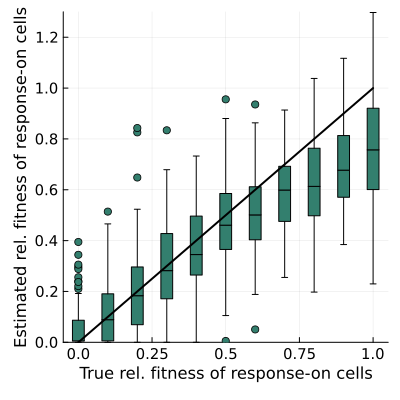

In [60]:
P_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*"/het_infer-div-number_cultures_50-gamma_on_$j.csv")))
    boxplot!([j], inferred_para[10,:], lab="", c=my_col[5])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.3))
plot!(collect(1:J), range_para, lab="", c=:black, width=2, tickfontsize=10)
plot!(xlab="True rel. fitness of response-on cells", ylab="Estimated rel. fitness of response-on cells")

In [61]:
savefig(P_inc_div, "figures/Figure_4A.pdf")
savefig(P_div, "figures/Figure_4B.pdf")

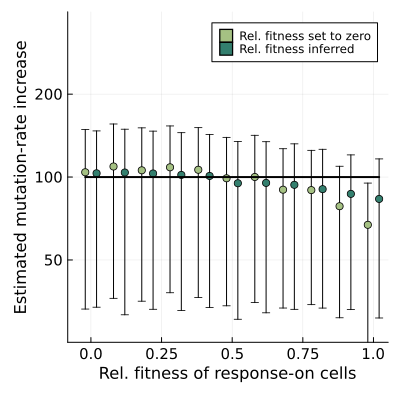

In [47]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# Estimated compared to true mutation-rate increase/rel. division rate of response-on cells (median confidence intervals)
m_1 = "/het_zero-div"
m_2 = "/het_infer-div"
P_inc_div_CI = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*m_1*"-number_cultures_50-gamma_on_$j.csv")))
    inferred_para_2 = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*m_2*"-number_cultures_50-gamma_on_$j.csv")))
    scatter!([j-0.4], [median(inferred_para_1[16,:])], yerror=([median(inferred_para_1[18,:].-inferred_para_1[16,:])], [median(inferred_para_1[16,:].-inferred_para_1[17,:])]), lab="", c=my_col[10])
    scatter!([j+0.4], [median(inferred_para_2[16,:])], yerror=([median(inferred_para_2[18,:].-inferred_para_2[16,:])], [median(inferred_para_2[16,:].-inferred_para_2[17,:])]), lab="", c=my_col[5])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Rel. fitness of response-on cells", ylab="Estimated mutation-rate increase")
scatter!([0], [1], lab="Rel. fitness set to zero", c=my_col[10], marker=:square)
scatter!([0], [1], lab="Rel. fitness inferred", c=my_col[5], marker=:square)

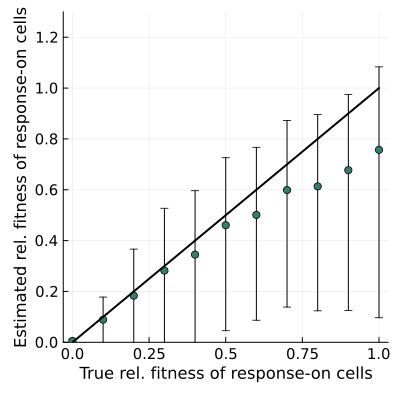

In [48]:
P_div_CI = plot(size=(400,400))
for j = 1:2:J
    inferred_para = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*"/het_infer-div-number_cultures_50-gamma_on_$j.csv")))
    scatter!([j], [median(inferred_para[10,:])], yerror=([median(inferred_para[12,:].-inferred_para[10,:])], [median(inferred_para[10,:].-inferred_para[11,:])]), lab="", c=my_col[5])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.3))
plot!(collect(1:J), range_para, lab="", c=:black, width=2, tickfontsize=10)
plot!(xlab="True rel. fitness of response-on cells", ylab="Estimated rel. fitness of response-on cells")

## Estimation when response-on cells have a known non-zero division rate.

In [63]:
# Reading the (true) input parameters
p = "range-gamma_on-increase100"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / gamma_off
J = length(range_para)
mu_off_true = nu_off/gamma_off
mu_on_true = true_para.nu_on[1]/gamma_off;

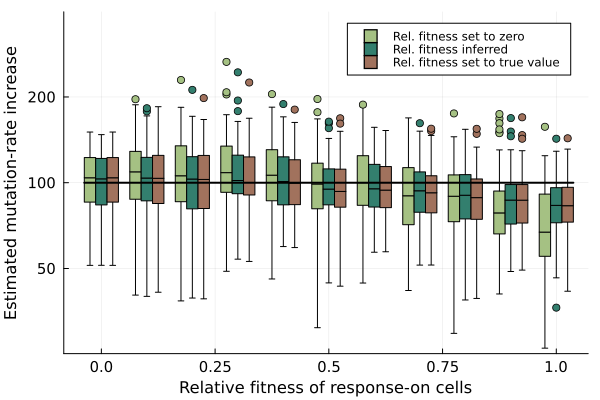

In [64]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# (iii) setting the rel. division rate to its true value
# Estimated compared to true mutation-rate increase 
m_1 = "/het_zero-div"
m_2 = "/het_infer-div"
m_3 = "/het_set-div"
P_inc_div_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_1 = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*m_1*"-number_cultures_50-gamma_on_$j.csv")))
    inferred_para_2 = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*m_2*"-number_cultures_50-gamma_on_$j.csv")))
    inferred_para_3 = Matrix(DataFrame(CSV.File("inferred_parameters/"*p*m_3*"-number_cultures_50-gamma_on_$j.csv")))
    boxplot!([j-0.5], inferred_para_1[16,:], lab="", c=my_col[10], bar_width=0.5)
    boxplot!([j], inferred_para_2[16,:], lab="", c=my_col[5], bar_width=0.5)
    boxplot!([j+0.5], inferred_para_3[16,:], lab="", c=my_col[2], bar_width=0.5)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutation-rate increase")
scatter!([0], [1], lab="Rel. fitness set to zero", c=my_col[10], marker=:square)
scatter!([0], [1], lab="Rel. fitness inferred", c=my_col[5], marker=:square)
scatter!([0], [1], lab="Rel. fitness set to true value", c=my_col[2], marker=:square)

In [65]:
savefig(P_inc_div_A, "figures/Figure_4A_set.pdf")

## Model selection

In [209]:
# Reading the (true) input parameters
# Mutation-rate increase = 100 or 10
i = 100
range_1 = "range-gamma_on-increase$i"
true_para = DataFrame(CSV.File("input_parameters/"*range_1*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / gamma_off
J = length(range_para)
mu_off_true = nu_off/gamma_off
mu_on_true = true_para.nu_on[1]/gamma_off
p_final = Matrix(DataFrame(CSV.File("output_data/p_final-"*range_1*".csv")))
mu_mean_true = p_final[2,:] .* mu_on_true .+ (1 .- p_final[2,:]) .* mu_off_true
del_mu_true = mu_mean_true[1:end-1]/mu_off_true
mu_het_true = (p_final[2,:] .* mu_on_true ./ ((1 .- p_final[2,:]) .* mu_off_true))[1:end-1];

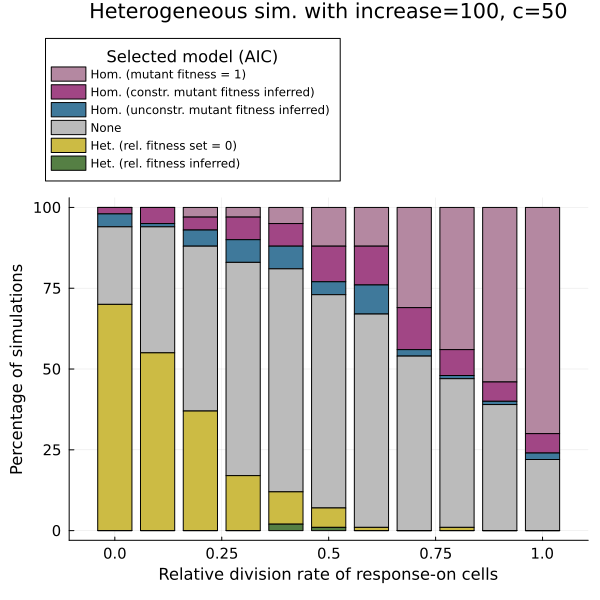

In [136]:
# Model selection via likelihood-ratio test + AIC/BIC between
# (i) Homogeneous-response model with mutant fitness set to one
# (ii) Homogeneous-response model with constrained mutant fitness permissive=stressful inferred
# (iii) Homogeneous-response model with unconstrained mutant fitness permissive/stressful inferred
# (iv) Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (v) Heterogeneous-response model with rel. division rate inferred (unknown f_on)
n = 50                                  # Also for smaller numbers of parallel cultures n=20,10
sm = ["LRT_constr","LRT","LRT","AIC_constr","BIC_constr","AIC","BIC","CV"]
s = 6
select_1 = Vector{Int}(undef, J)
select_2 = Vector{Int}(undef, J)
select_3 = Vector{Int}(undef, J)
select_4 = Vector{Int}(undef, J)
select_5 = Vector{Int}(undef, J)
select_0 = Vector{Int}(undef, J)
for j = 1:2:J
    selected_m = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_1*"/selected_model-number_cultures_$n-gamma_on_$j.csv")))
    select_1[j] = sum(selected_m[s,:] .== 1)
    select_2[j] = sum(selected_m[s,:] .== 2)
    select_3[j] = sum(selected_m[s,:] .== 3)
    select_4[j] = sum(selected_m[s,:] .== 4)
    select_5[j] = sum(selected_m[s,:] .== 5)
    select_0[j] = sum(selected_m[s,:] .== 0)
end
P_select = groupedbar([select_1[1:2:J] select_2[1:2:J] select_3[1:2:J] select_0[1:2:J] select_4[1:2:J] select_5[1:2:J]], bar_position=:stack, c=[my_col[16] my_col[14] my_col[6] my_col[17] my_col[9] my_col[3]], label=["Hom. (mutant fitness = 1)" "Hom. (constr. mutant fitness inferred)" "Hom. (unconstr. mutant fitness inferred)" "None" "Het. (rel. fitness set = 0)" "Het. (rel. fitness inferred)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=10)
plot!(size=(600,600), xlab="Relative division rate of response-on cells", ylab="Percentage of simulations", title="Heterogeneous sim. with increase=$i, c=$n", legend_title="Selected model ($(sm[s]))", legend=:outertop)
#plot!(legend=:false)

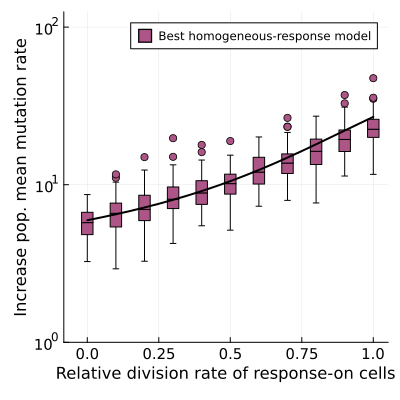

In [148]:
# Reading and plotting the inferred parameters
# Estimation methods: Homogeneous-response models
# Estimated fold-change in population mean mutation rate and mutant fitness under stressful conditions
m = ["/hom_wo-fitm", "/hom_fitm", "/hom_fitm-unconstr", "/het_zero-div_unknown-f", "/het_infer-div_unknown-f"]
P_mean = plot(size=(400,400))
for j = 1:2:J
    hom_1 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[1])-number_cultures_$n-gamma_on_$j.csv"))[13,:])
    hom_2 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[2])-number_cultures_$n-gamma_on_$j.csv"))[13,:])
    hom_3 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[3])-number_cultures_$n-gamma_on_$j.csv"))[13,:])
    selected_m = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"/selected_model-number_cultures_$n-gamma_on_$(j).csv"))[2,:])
    hom_1 = hom_1[selected_m .== 1]
    hom_2 = hom_2[selected_m .== 2]
    hom_3 = hom_3[selected_m .== 3]
    hom = [hom_1; hom_2; hom_3]
    boxplot!([j], hom, lab="", c=my_col[15])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), tickfontsize=10, yscale=:log10, ylim=(1,125))
plot!(collect(1:J), del_mu_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Relative division rate of response-on cells", ylab="Increase pop. mean mutation rate")
scatter!([0], [0.1], lab="Best homogeneous-response model", c=my_col[15], marker=:square)
#plot!(ylim=(1,8), yticks=([1,2,4,8], [1,2,4,8]))

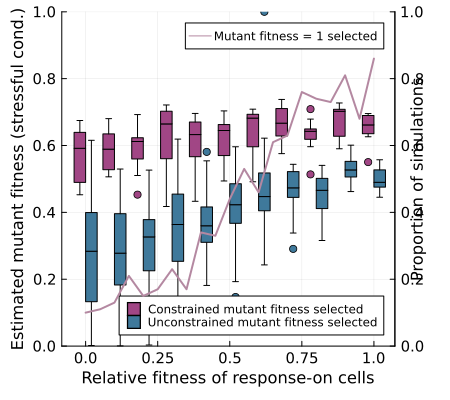

In [213]:
P_rho = plot(size=(450,400))
rho_1 = zeros(Int, J)
for j = 1:2:J
    hom_1 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[1])-number_cultures_$n-gamma_on_$j.csv"))[10,:])
    hom_2 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[2])-number_cultures_$n-gamma_on_$j.csv"))[10,:])
    hom_3 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[3])-number_cultures_$n-gamma_on_$j.csv"))[10,:])
    selected_m = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"/selected_model-number_cultures_$n-gamma_on_$(j).csv"))[2,:])
    hom_2 = hom_2[selected_m .== 2]
    hom_3 = hom_3[selected_m .== 3]
    if length(hom_2) == 0
        hom_2 = [-1]
    end
    if length(hom_3) == 0
        hom_3 = [-1]
    end
    boxplot!([j-0.4], hom_2, lab="", c=my_col[14])
    boxplot!([j+0.4], hom_3, lab="", c=my_col[6])
end
for j = 1:J
    selected_m = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"/selected_model-number_cultures_$n-gamma_on_$(j).csv"))[2,:])
    rho_1[j] = sum(selected_m .== 1)
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.), tickfontsize=10, rightmargin=12mm)
plot!(xlab="Relative fitness of response-on cells", ylab="Estimated mutant fitness (stressful cond.)")
scatter!([0], [-1], lab="Constrained mutant fitness selected", c=my_col[14], marker=:square, legend=:bottomright)
scatter!([0], [-1], lab="Unconstrained mutant fitness selected", c=my_col[6], marker=:square)
#plot!(legend=:false)
plot!(twinx(), collect(1:J), rho_1./100, xticks=false, ylim=(0,1), tickfontsize=10, c=my_col[16], width=2, lab="Mutant fitness = 1 selected")
plot!(twinx(), xticks=[], yticks=[], ylab="Proportion of simulations")

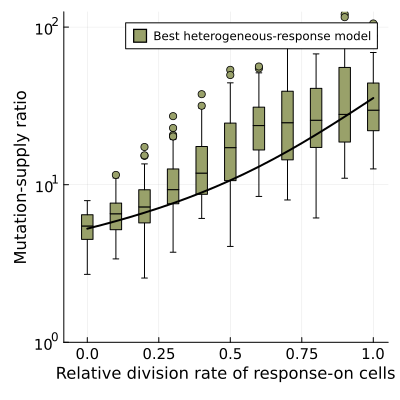

In [121]:
# Reading and plotting the inferred parameters
# Estimation methods: Heterogeneous-response model (unknown f_on)
# Estimated mutation-supply ratio and mutation-rate increase calculated from S and M
m = ["/hom_wo-fitm", "/hom_fitm", "/hom_fitm-unconstr", "/het_zero-div_unknown-f", "/het_infer-div_unknown-f"]
P_mu_het = plot(size=(400,400))
for j = 1:2:J
    het_4 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[4])-number_cultures_$n-gamma_on_$j.csv"))[4,:])
    het_5 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[5])-number_cultures_$n-gamma_on_$j.csv"))[4,:])
    selected_m = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"/selected_model-number_cultures_$n-gamma_on_$(j).csv"))[3,:])
    het_4 = het_4[selected_m .== 4]
    het_5 = het_5[selected_m .== 5]
    het = [het_4; het_5]
    boxplot!([j], het, lab="", c=my_col[8])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), tickfontsize=10, yscale=:log10, ylim=(1,125))
plot!(collect(1:J), mu_het_true, c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Relative division rate of response-on cells", ylab="Mutation-supply ratio")
scatter!([0], [-0.1], lab="Best heterogeneous-response model", c=my_col[8], marker=:square)
#plot!(ylim=(10^-2,10^2))

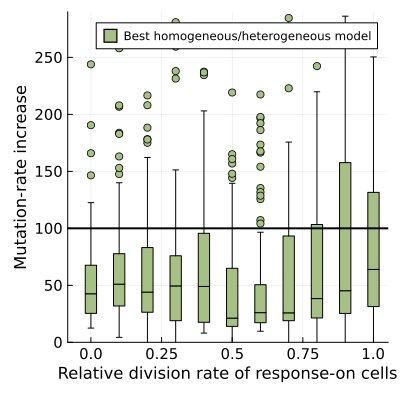

In [100]:
P_inc = plot(size=(400,400))
for j = 1:2:J
    hom_1 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[1])-number_cultures_$n-gamma_on_$j.csv"))[13,:])
    hom_2 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[2])-number_cultures_$n-gamma_on_$j.csv"))[13,:])
    hom_3 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[3])-number_cultures_$n-gamma_on_$j.csv"))[13,:])
    hom = [hom_1 hom_2 hom_3]
    s_hom = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"/selected_model-number_cultures_$n-gamma_on_$(j).csv"))[2,:])
    het_4 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[4])-number_cultures_$n-gamma_on_$j.csv"))[4,:])
    het_5 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"$(m[5])-number_cultures_$n-gamma_on_$j.csv"))[4,:])
    het = [het_4 het_5]
    s_het = Vector(DataFrame(CSV.File("inferred_parameters/"*range_1*"/selected_model-number_cultures_$n-gamma_on_$(j).csv"))[3,:])
    inc = Vector{Float64}(undef, length(hom_1))
    for k = 1:length(hom_1)
        inc[k] = het[k, s_het[k]-3] * hom[k, s_hom[k]]/(1 + het[k, s_het[k]-3] - hom[k, s_hom[k]])
    end
    boxplot!([j], inc, lab="", c=my_col[10])
end
plot!(xticks=(collect(1:5:J), range_para[1:5:J]), tickfontsize=10, ylim=(0,290))
hline!([i], c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Relative division rate of response-on cells", ylab="Mutation-rate increase")
scatter!([0], [-1.], lab="Best homogeneous/heterogeneous model", c=my_col[10], marker=:square)

In [214]:
savefig(P_select, "figures/Figure_5A_$(n)_$(i)_$(sm[s]).pdf")
savefig(P_mu_het, "figures/Figure_5B_$(n)_$i.pdf")
savefig(P_mean, "figures/Figure_5C_$(n)_$(i)_$(sm[s]).pdf")
savefig(P_rho, "figures/Figure_5D_$(n)_$(i)_$(sm[s]).pdf")
savefig(P_inc, "figures/Figure_5E_$(n)_$i.pdf")

## Model selection when simulating under the homogeneous model 

In [190]:
# Reading the (true) input parameters
# Constrained or unconstrained mutant fitness
range_1 = "range-nu_off_s"
range_2 = "range-rho"
range_p = "-rho"
true_para_1 = DataFrame(CSV.File("input_parameters/"*range_1*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*range_2*".csv"))
range_para_1 = collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) / gamma_off
range_para_2 = collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1])
J1 = length(range_para_1)
J2 = length(range_para_2)
range_2 *= "/"
J2 = 21;

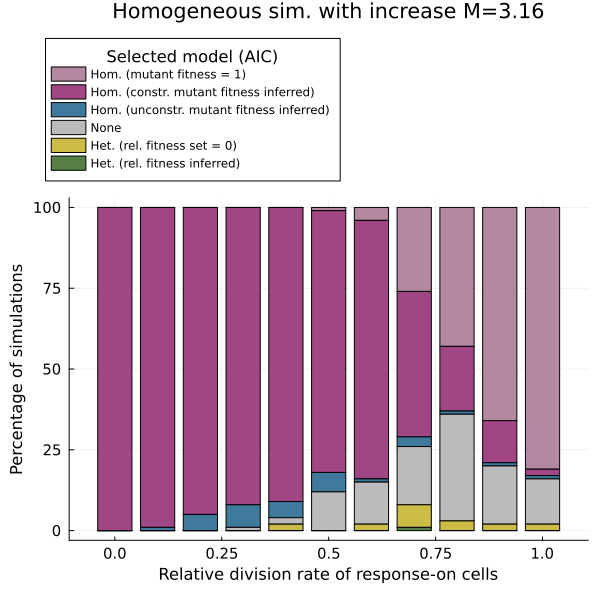

In [207]:
# Model selection via likelihood-ratio test + AIC/BIC between
# (i) Homogeneous-response model with mutant fitness set to one
# (ii) Homogeneous-response model with constrained mutant fitness permissive=stressful inferred
# (iii) Homogeneous-response model with unconstrained mutant fitness permissive/stressful inferred
# (iv) Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (v) Heterogeneous-response model with rel. division rate inferred (unknown f_on)
m = ["/hom_wo-fitm", "/hom_fitm", "/hom_fitm-unconstr", "/het_zero-div_unknown-f", "/het_infer-div_unknown-f"]
sm = ["LRT_constr","LRT","LRT","AIC_constr","BIC_constr","AIC","BIC","CV"]
s = 6
j1 = 2                              # Fold-change in population mean mutation rate
select_1 = Vector{Int}(undef, J2)
select_2 = Vector{Int}(undef, J2)
select_3 = Vector{Int}(undef, J2)
select_4 = Vector{Int}(undef, J2)
select_5 = Vector{Int}(undef, J2)
select_0 = Vector{Int}(undef, J2)
for j2 = 1:2:J2
    selected_m = Matrix(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$j2/selected_model-number_cultures_50-log_nu_off_s_$j1.csv")))
    select_1[j2] = sum(selected_m[s,:] .== 1) 
    select_2[j2] = sum(selected_m[s,:] .== 2)
    select_3[j2] = sum(selected_m[s,:] .== 3)
    select_4[j2] = sum(selected_m[s,:] .== 4)
    select_5[j2] = sum(selected_m[s,:] .== 5)
    select_0[j2] = sum(selected_m[s,:] .== 0)
end
P_hom_select = groupedbar([select_1[1:2:J] select_2[1:2:J] select_3[1:2:J] select_0[1:2:J] select_4[1:2:J] select_5[1:2:J]], bar_position=:stack, c=[my_col[16] my_col[14] my_col[6] my_col[17] my_col[9] my_col[3]], label=["Hom. (mutant fitness = 1)" "Hom. (constr. mutant fitness inferred)" "Hom. (unconstr. mutant fitness inferred)" "None" "Het. (rel. fitness set = 0)" "Het. (rel. fitness inferred)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=10)
plot!(size=(600,600), xlab="Relative division rate of response-on cells", ylab="Percentage of simulations", title="Homogeneous sim. with increase M=$(round(10^range_para_1[j1]/nu_off,digits=2))", legend_title="Selected model ($(sm[s]))", legend=:outertop)
#plot!(legend=:false)

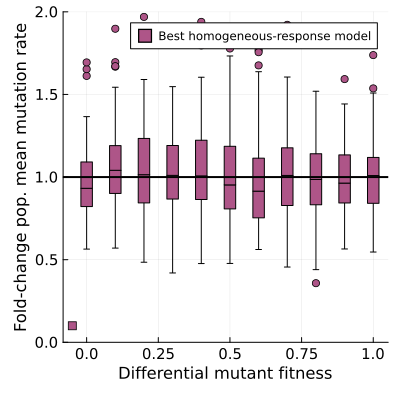

In [169]:
# Reading and plotting the inferred parameters
# Homogeneous-response models -> Estimated fold-change in population mean mutation rate
# Heterogeneous-response models -> Estimated mutation-supply ratio
m = ["/hom_wo-fitm", "/hom_fitm", "/hom_fitm-unconstr", "/het_zero-div_unknown-f", "/het_infer-div_unknown-f"]
P_hom_mean = plot(size=(400,400))
for j2 = 1:2:J2
    hom_1 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$(j2)$(m[1])-number_cultures_50-log_nu_off_s_$j1.csv"))[13,:])
    hom_2 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$(j2)$(m[2])-number_cultures_50-log_nu_off_s_$j1.csv"))[13,:])
    hom_3 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$(j2)$(m[3])-number_cultures_50-log_nu_off_s_$j1.csv"))[13,:])
    selected_m = Vector(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$j2/selected_model-number_cultures_50-log_nu_off_s_$j1.csv"))[2,:])
    hom_1 = hom_1[selected_m .== 1]
    hom_2 = hom_2[selected_m .== 2]
    hom_3 = hom_3[selected_m .== 3]
    hom = [hom_1; hom_2; hom_3]
    boxplot!([j2], hom, lab="", c=my_col[15])
end
plot!(xticks=(collect(1:5:J2), range_para_2[1:5:J2])),# yscale=:log10, ylim=(10^range_para_1[j1]/(5*nu_off), 10^range_para_1[j1]*5/nu_off), yticks=([1,2,5,10,20,40,80], [1,2,5,10,20,40,80]))
hline!([10^range_para_1[j1]/nu_off], c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Differential mutant fitness", ylab="Fold-change pop. mean mutation rate")
scatter!([0], [0.1], lab="Best homogeneous-response model", c=my_col[15], marker=:square)
plot!(ylim=(0,2))

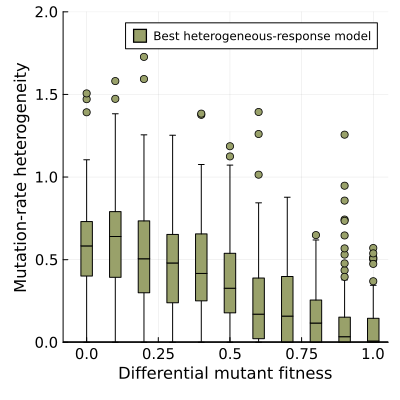

In [170]:
P_hom_mu_het = plot(size=(400,400))
for j2 = 1:2:J2
    het_4 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$(j2)$(m[4])-number_cultures_50-log_nu_off_s_$j1.csv"))[4,:])
    het_5 = Vector(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$(j2)$(m[5])-number_cultures_50-log_nu_off_s_$j1.csv"))[4,:])
    selected_m = Vector(DataFrame(CSV.File("inferred_parameters/"*range_2*range_1*range_p*"_$j2/selected_model-number_cultures_50-log_nu_off_s_$j1.csv"))[3,:])
    het_4 = het_4[selected_m .== 4]
    het_5 = het_5[selected_m .== 5]
    het = [het_4; het_5]
    boxplot!([j2], het, lab="", c=my_col[8])
end
plot!(xticks=(collect(1:5:J2), range_para_2[1:5:J2]), ylim=(0., 5*10^range_para_1[j1]/nu_off))#, yticks=([1,2,5,10,20,40], [1,2,5,10,20,40]))
hline!([0], c=:black, width=2, lab="", tickfontsize=10)
plot!(xlab="Differential mutant fitness", ylab="Mutation-rate heterogeneity")
scatter!([0], [-0.1], lab="Best heterogeneous-response model", c=my_col[8], marker=:square)
plot!(ylim=(0,2))

In [208]:
savefig(P_hom_select, "figures/Figure_5A"*range_p*"_$(Int(round(10^range_para_1[j1]/nu_off,digits=0)))_$(sm[s]).pdf")
savefig(P_hom_mu_het, "figures/Figure_5B"*range_p*"_$(Int(round(10^range_para_1[j1]/nu_off,digits=0)))_$(sm[s]).pdf")
savefig(P_hom_mean, "figures/Figure_5C"*range_p*"_$(Int(round(10^range_para_1[j1]/nu_off,digits=0)))_$(sm[s]).pdf")

## Testing the validity of the assumption that the response-on subpopulation can be treated deterministically

In [226]:
# Reading the (true) input parameters
f = "fstat"
range_1 = "range-gamma_on-increase100"
range_2 = "range-alpha-"*f
true_para_1 = DataFrame(CSV.File("input_parameters/"*range_1*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*range_2*".csv"))
range_para_1 = collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) 
range_para_2 = 10 .^ collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1])
J1 = length(range_para_1)
J2 = length(range_para_2)
f0_on = true_para_2.f0_on[1]
mu_on = true_para_1.nu_on[1]/gamma_off;

In [227]:
# Reading and plotting the output data
# Comparing with determinist equation for the size of the response-on subpopulation
include("population_dynamics.jl")
# Relative error and coefficient of variation across the simulations
RE_alpha_div_t1 = Matrix{Float64}(undef, (J1, J2))
CV_alpha_div_t1 = Matrix{Float64}(undef, (J1, J2))
RE_alpha_div_tf = Matrix{Float64}(undef, (J1, J2))
CV_alpha_div_tf = Matrix{Float64}(undef, (J1, J2))
for j2 = 1:J2
    N_on_t1 = DataFrame(CSV.File("output_data/"*range_2*"/n_t1-"*range_1*"-log_alpha_$j2.csv"))
    N_on_tf = DataFrame(CSV.File("output_data/"*range_2*"/n_tf-"*range_1*"-log_alpha_$j2.csv"))
    if f == "fstat"
        f0_on = range_para_2[j2]/(gamma_off-delta_off)
    end
    tf = t_final(N0, gamma_off-range_para_2[j2], Nf) 
    t1 = t_first_m(N0, gamma_off-range_para_2[j2], nu_off/gamma_off*(1-f0_on)+nu_on/gamma_off*f0_on)
    for j1 = 1:J1
        RE_alpha_div_t1[j1, j2] = (median(N_on_t1[:,j1]) - pop_size(t1, N0*(1-f0_on), gamma_off-range_para_2[j2], range_para_2[j2], N0*f0_on, range_para_1[j1])) / pop_size(t1, N0*(1-f0_on), gamma_off-range_para_2[j2], range_para_2[j2], N0*f0_on, range_para_1[j1])
        RE_alpha_div_tf[j1, j2] = (median(N_on_tf[:,j1]) - pop_size(tf, N0*(1-f0_on), gamma_off-range_para_2[j2], range_para_2[j2], N0*f0_on, range_para_1[j1])) / pop_size(tf, N0*(1-f0_on), gamma_off-range_para_2[j2], range_para_2[j2], N0*f0_on, range_para_1[j1])
        CV_alpha_div_t1[j1, j2] = std(N_on_t1[:,j1]) / mean(N_on_t1[:,j1])
        CV_alpha_div_tf[j1, j2] = std(N_on_tf[:,j1]) / mean(N_on_tf[:,j1])
    end
end

In [217]:
# Determining numerical values for the precision
println([maximum(abs.(RE_alpha_div_t1)), maximum(abs.(CV_alpha_div_t1))])
println([maximum(abs.(RE_alpha_div_tf)), maximum(abs.(CV_alpha_div_tf))])

[0.011650629219946097, 0.05714352948557632]
[0.008893672126770915, 0.04354880953247567]


Initial fraction = 0.1

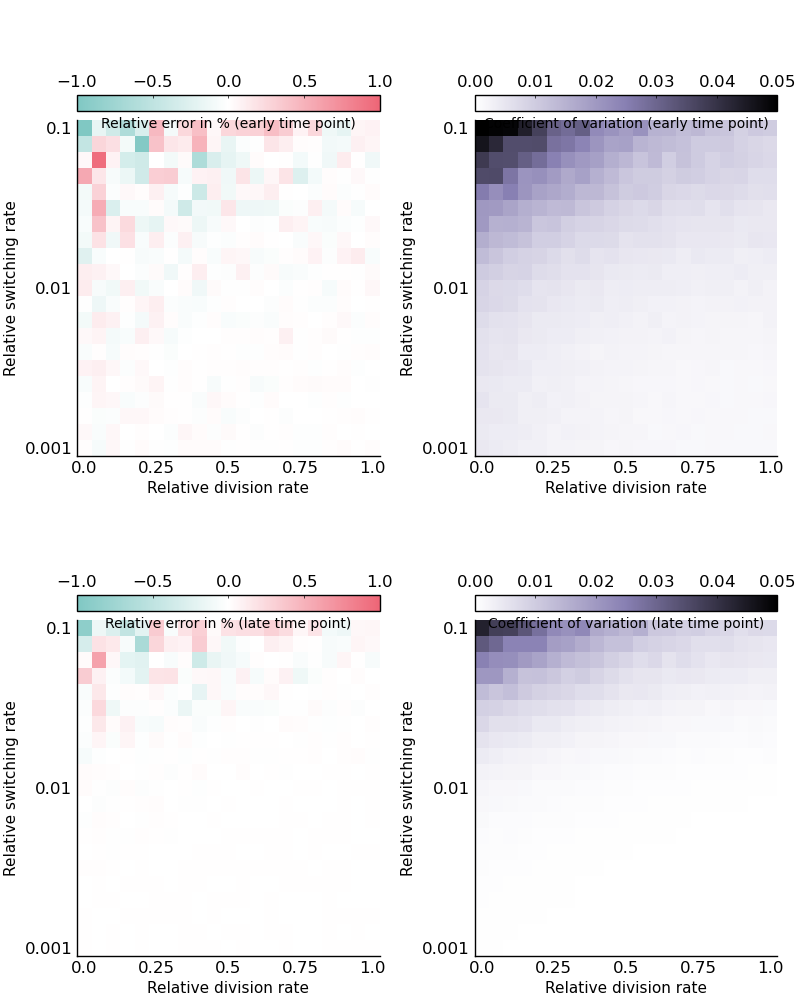

In [218]:
pyplot()
print("Initial fraction = $(f0_on)")
c_max = 1
c_min = -1
P_RE_t1 = plot(size=(400,500))
heatmap!(100 .*RE_alpha_div_t1, c=cgrad([my_col[11], :white, my_col[1]], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max), cb=:top, colorbar_tickfontsize=12)
plot!(xticks=(collect(1:5:J1), range_para_1[1:5:J1]/gamma_off), yticks=(collect(1:10:J2), range_para_2[1:10:J2]/gamma_off), tickfontsize=12)
plot!(colorbar_title="Relative error in % (early time point)", ylab="Relative switching rate", xlab="Relative division rate")
P_RE_tf = plot(size=(400,500))
heatmap!(100 .*RE_alpha_div_tf, c=cgrad([my_col[11], :white, my_col[1]], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max), cb=:top, colorbar_tickfontsize=12)
plot!(xticks=(collect(1:5:J1), range_para_1[1:5:J1]/gamma_off), yticks=(collect(1:10:J2), range_para_2[1:10:J2]/gamma_off), tickfontsize=12)
plot!(colorbar_title="Relative error in % (late time point)", ylab="Relative switching rate", xlab="Relative division rate")
c_max = 0.05
P_CV_t1 = plot(size=(400,500))
heatmap!(CV_alpha_div_t1, c=cgrad([:white, my_col[13], :black]), clim=(0, c_max))
plot!(xticks=(collect(1:5:J1), range_para_1[1:5:J1]/gamma_off), yticks=(collect(1:10:J2), range_para_2[1:10:J2]/gamma_off), tickfontsize=12, cb=:top, colorbar_tickfontsize=12)
plot!(colorbar_title="Coefficient of variation (early time point)", ylab="Relative switching rate", xlab="Relative division rate")
P_CV_tf = plot(size=(400,500))
heatmap!(CV_alpha_div_tf, c=cgrad([:white, my_col[13], :black]), clim=(0, c_max))
plot!(xticks=(collect(1:5:J1), range_para_1[1:5:J1]/gamma_off), yticks=(collect(1:10:J2), range_para_2[1:10:J2]/gamma_off), tickfontsize=12, cb=:top, colorbar_tickfontsize=12)
plot!(colorbar_title="Coefficient of variation (late time point)", ylab="Relative switching rate", xlab="Relative division rate")
plot(P_RE_t1, P_CV_t1, P_RE_tf, P_CV_tf, size=(800, 1000))

In [93]:
savefig(P_RE_t1, "figures/Figure_A_1A$f.png")
savefig(P_RE_tf, "figures/Figure_A_1B$f.png")
savefig(P_CV_t1, "figures/Figure_A_1C$f.png")
savefig(P_CV_tf, "figures/Figure_A_1D$f.png")
gr()

Plots.GRBackend()